# Optimizing for a specific Prompt starting from Random Embeddings with ClipScore and SDXL Turbo

In [36]:
from evolutionary.plotting import plot_fitness_statistics
from diffusers.utils import logging
from evolutionary_imaging.processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation
import torch

In [ ]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems

def save_images_post_evaluation(g, a):
    save_images_from_generation(a.population, g)
    
# Check torch random state, used across all libraries. Caution setting fixed seeds as it affects not only generation but also variation.
print(torch.random.get_rng_state())

In [22]:
from evolutionary_prompt_embedding.argument_types import PooledPromptEmbedData
from evolutionary_prompt_embedding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary_prompt_embedding.variation import \
    UniformGaussianMutatorArguments, PooledUniformGaussianMutator, PooledArithmeticCrossover
from evolutionary_prompt_embedding.value_ranges import SDXLTurboEmbeddingRange, SDXLTurboPooledEmbeddingRange
from evolutionary.selectors import TournamentSelector
from evolutionary.algorithms.ga import GeneticAlgorithm
from evolutionary_imaging.evaluators import CLIPScoreEvaluator

population_size = 100
num_generations = 200
batch_size = 1
elitism = 1
inference_steps = 3
prompt = "surreal simulation of the universe, fantasy crazy unimaginable 4k high quality ultra hd beautiful"

embedding_range = SDXLTurboEmbeddingRange()
pooled_embedding_range = SDXLTurboPooledEmbeddingRange()
creator = SDXLPromptEmbeddingImageCreator(batch_size=batch_size, inference_steps=inference_steps)
evaluator = CLIPScoreEvaluator(prompt=prompt) 
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=3, 
                                                     clamp_range=(embedding_range.minimum, embedding_range.maximum)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.05, mutation_strength=0.7, 
                                                            clamp_range=(pooled_embedding_range.minimum, pooled_embedding_range.maximum))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments, random population of *reasonable* prompt embeddings
init_args = [PooledPromptEmbedData(embedding_range.random_tensor_in_range(), pooled_embedding_range.random_tensor_in_range()) 
             for _ in range(population_size)]

ga = GeneticAlgorithm(
    population_size=population_size,
    num_generations=num_generations,
    solution_creator=creator,
    evaluator=evaluator,
    mutator=mutator,
    crossover=crossover,
    selector=selector,
    initial_arguments=init_args,
    elitism_count=elitism,
    post_evaluation_callback=save_images_post_evaluation,
)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


In [23]:
best_solution = ga.run()

Generation 0 started.
Generation 1 started.
Generation 2 started.
Generation 3 started.
Generation 4 started.
Generation 5 started.
Generation 6 started.
Generation 7 started.
Generation 8 started.
Generation 9 started.
Generation 10 started.
Generation 11 started.
Generation 12 started.
Generation 13 started.
Generation 14 started.
Generation 15 started.
Generation 16 started.
Generation 17 started.
Generation 18 started.
Generation 19 started.
Generation 20 started.
Generation 21 started.
Generation 22 started.
Generation 23 started.
Generation 24 started.
Generation 25 started.
Generation 26 started.
Generation 27 started.
Generation 28 started.
Generation 29 started.
Generation 30 started.
Generation 31 started.
Generation 32 started.
Generation 33 started.
Generation 34 started.
Generation 35 started.
Generation 36 started.
Generation 37 started.
Generation 38 started.
Generation 39 started.
Generation 40 started.
Generation 41 started.
Generation 42 started.
Generation 43 started

33.497589111328125


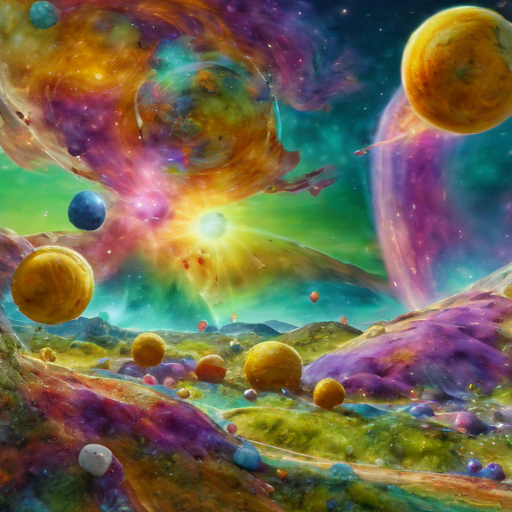

In [28]:
from diffusers.utils import make_image_grid

# Show best solution
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Compare to directly generating it with the prompt

In [37]:
creator_compare = SDXLPromptEmbeddingImageCreator(batch_size=10, inference_steps=inference_steps)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}


29.829121398925782


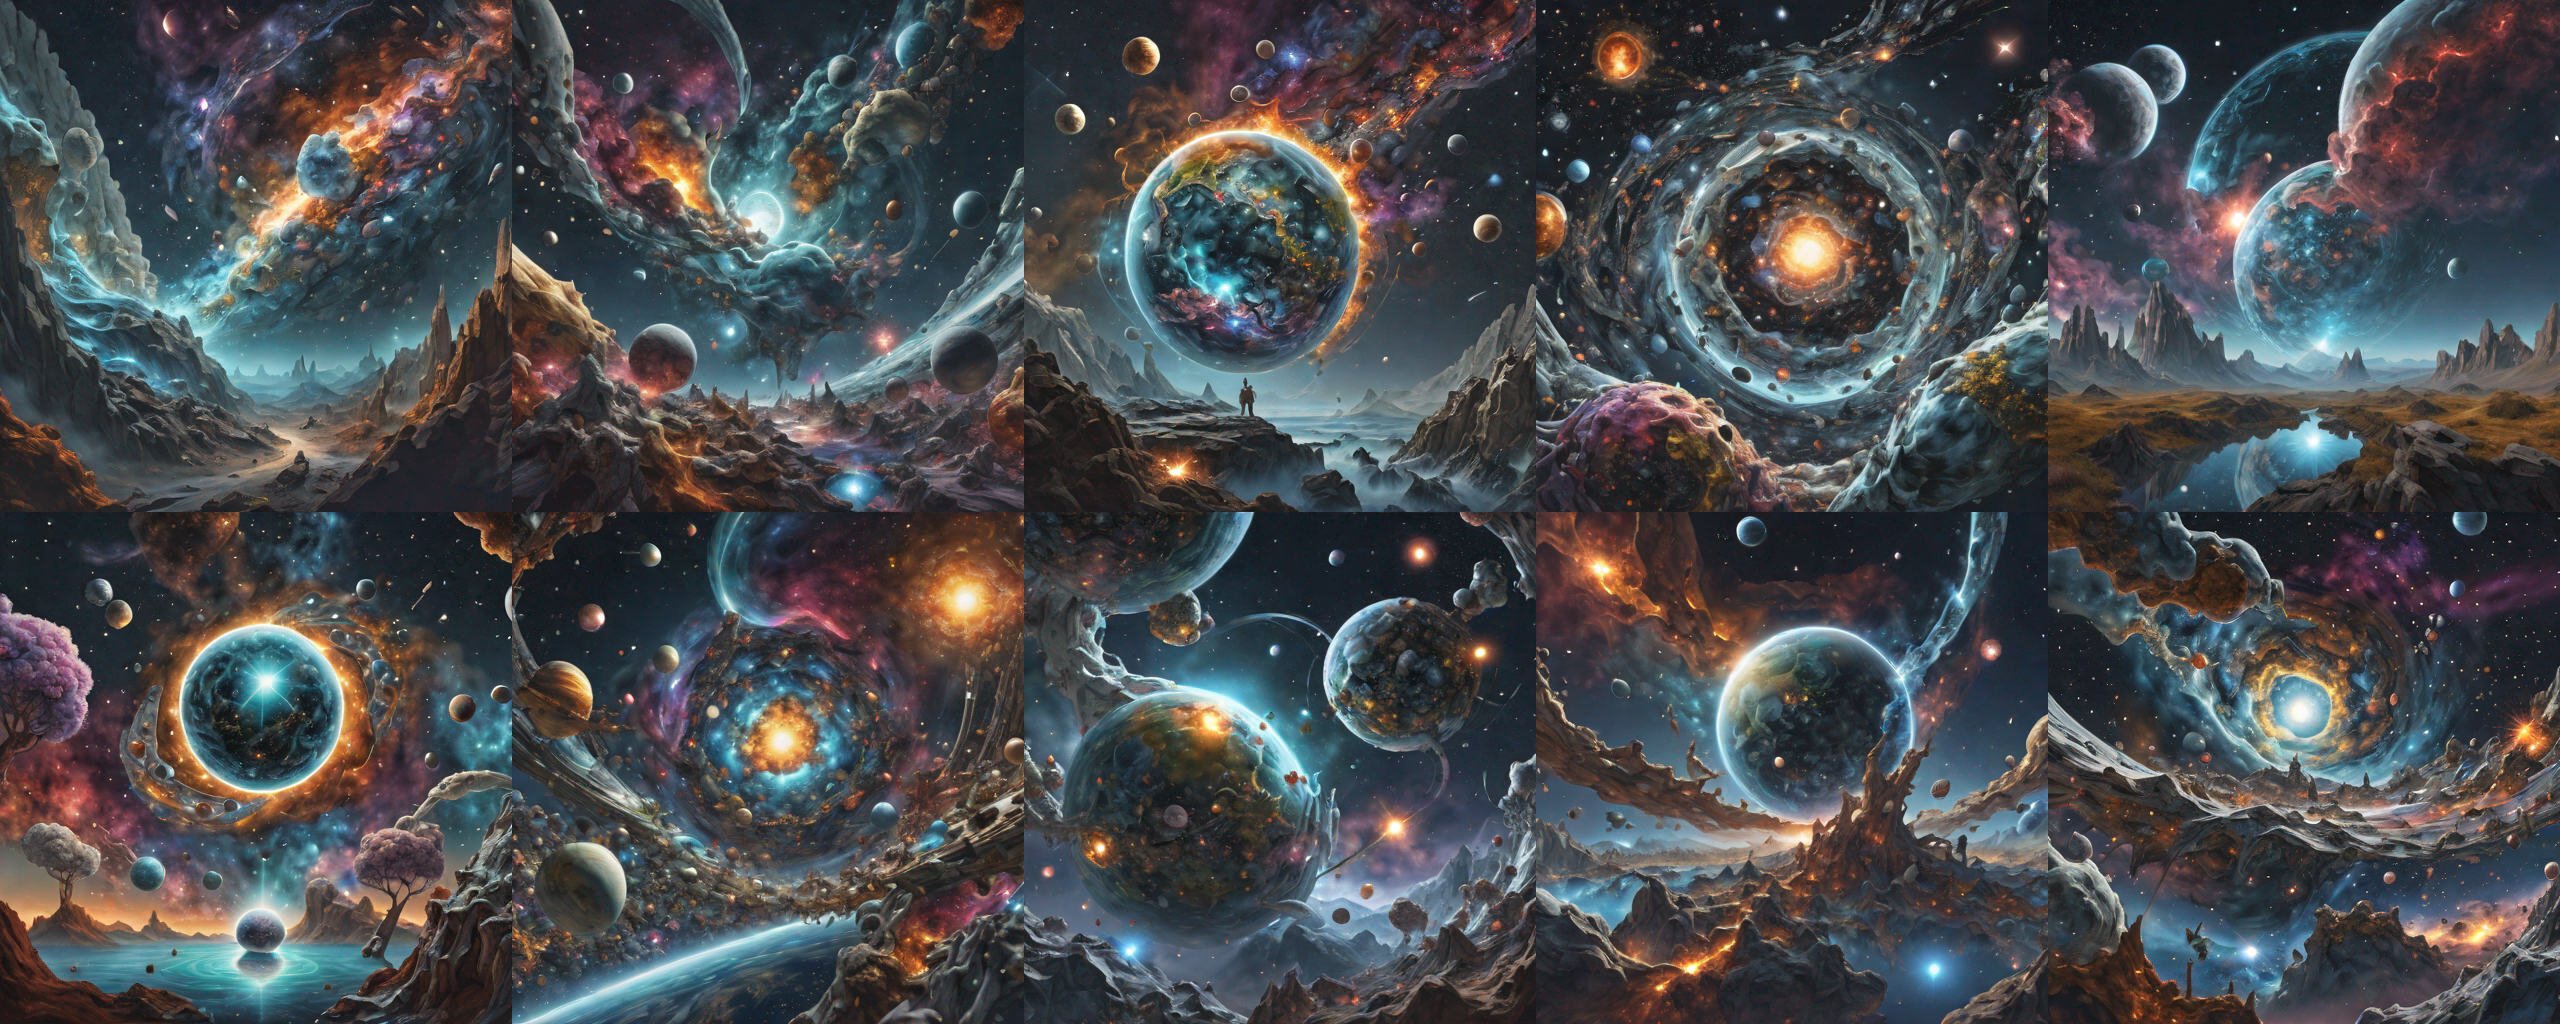

In [40]:
args = creator_compare.arguments_from_prompt(prompt)
solution = creator_compare.create_solution(args)
print(evaluator.evaluate(solution.result))
make_image_grid(solution.result.images, 2, 5)

## Plot fitness statistics

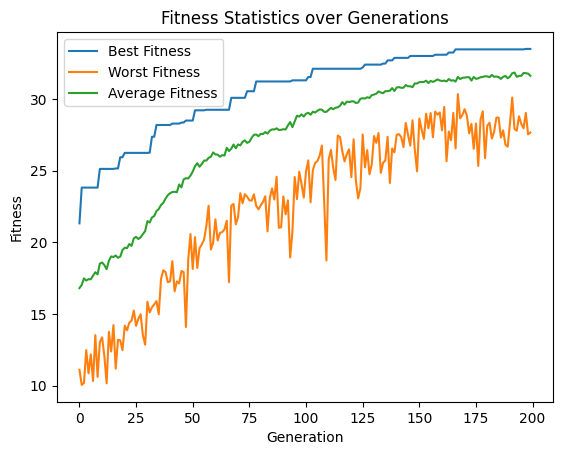

In [31]:
plot_fitness_statistics(num_generations, ga.best_fitness, ga.worst_fitness, ga.avg_fitness)